Importing required libraries

In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

Loading the data file (pickle format) and setting the interval to 5 minutues

In [3]:
path = "../Data/"
building = "avenal-animal-shelter"
interval = 5 # min


with open(path + building + "_training_data.pkl", 'rb') as f:
    train = pickle._Unpickler(f)
    train.encoding = 'latin1'
    training_data = train.load()

with open(path + building + "_test_data.pkl", "rb") as f:
    test = pickle._Unpickler(f)
    test.encoding = 'latin1'
    test_data = test.load()
    
print("training_data: ", training_data)
print("test_data: ", test_data)

training_data:                             action action_duration   dt  previous_action  \
time                                                                      
2018-04-18 23:16:42+00:00     0.0          300.0s  5.0              NaN   
2018-04-18 23:21:42+00:00     0.0          600.0s  5.0              NaN   
2018-04-18 23:26:42+00:00     0.0          900.0s  5.0              NaN   
2018-04-18 23:31:42+00:00     0.0         1200.0s  5.0              NaN   
2018-04-18 23:36:42+00:00     0.0         1500.0s  5.0              NaN   
2018-04-18 23:41:42+00:00     0.0         1800.0s  5.0              NaN   
2018-04-18 23:46:42+00:00     0.0         2100.0s  5.0              NaN   
2018-04-18 23:51:42+00:00     0.0         2400.0s  5.0              NaN   
2018-04-18 23:56:42+00:00     0.0         2700.0s  5.0              NaN   
2018-04-19 00:01:42+00:00     0.0         3000.0s  5.0              NaN   
2018-04-19 00:06:42+00:00     0.0         3300.0s  5.0              NaN   
2018-04-1

In [4]:
training_data.describe()

,action,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor
count,53187.000000,53187.000000,42307.000000,53187.000000,53187.000000,53186.000000,53186.000000,53186.000000
mean,0.398312,4.778348,1.708464,73.059279,73.059203,77.540013,0.095379,73.059306
std,1.101808,0.918377,0.770291,3.325702,3.326598,11.937110,0.291387,3.324545
min,0.000000,0.000000,0.000000,61.537931,55.840000,44.604843,0.000000,61.623430
25%,0.000000,5.000000,2.000000,70.600000,70.600000,68.499905,0.000000,70.595737
50%,0.000000,5.000000,2.000000,73.600000,73.600000,77.999684,0.000000,73.593218
75%,0.000000,5.000000,2.000000,75.400000,75.400000,86.999900,0.000000,75.417241
max,5.000000,5.000000,5.000000,81.100000,81.100000,104.000000,1.000000,81.100000


In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53187 entries, 2018-04-18 23:16:42+00:00 to 2018-10-25 23:13:42+00:00
Data columns (total 9 columns):
action                                        53187 non-null float64
action_duration                               53187 non-null object
dt                                            53187 non-null float64
previous_action                               42307 non-null float64
t_next                                        53187 non-null float64
t_in                                          53187 non-null float64
t_out                                         53186 non-null float64
occ                                           53186 non-null float64
zone_temperatureHVAC_Zone_Shelter_Corridor    53186 non-null float64
dtypes: float64(8), object(1)
memory usage: 4.1+ MB


Adding additional feature 't_last'. It indicates 't_in' at time 'dt' before from the current time index.

A timedelta object represents a duration, the difference between two dates or times.


In [6]:
def add_last_temperature_feature(data):
    """Adding a feature which specifies what the previous temperature was "dt" seconds before the current
    datasample. Since data does not need be continious, we need a loop.
    :param: pd.df with cols: "t_in", "dt" and needs to be sorted by time.
    returns pd.df with cols "t_last" added. """

    last_temps = []

    last_temp = None
    curr_time = data.index[0]
    for index, row in data.iterrows():

        if last_temp is None:
            last_temps.append(row["t_in"])  # so the feature will be zero instead
        else:
            last_temps.append(last_temp)

        if curr_time == index:
            last_temp = row["t_in"]
            curr_time += datetime.timedelta(minutes=row["dt"])
        else:
            last_temp = None
            curr_time = index + datetime.timedelta(minutes=row["dt"])

    data["t_last"] = np.array(last_temps)
    return data

training_data = add_last_temperature_feature(training_data)
test_data = add_last_temperature_feature(test_data)

print("training_data: ", training_data.head(10))
print("test_data: ", test_data)


training_data:                             action action_duration   dt  previous_action  \
time                                                                      
2018-04-18 23:16:42+00:00     0.0          300.0s  5.0              NaN   
2018-04-18 23:21:42+00:00     0.0          600.0s  5.0              NaN   
2018-04-18 23:26:42+00:00     0.0          900.0s  5.0              NaN   
2018-04-18 23:31:42+00:00     0.0         1200.0s  5.0              NaN   
2018-04-18 23:36:42+00:00     0.0         1500.0s  5.0              NaN   
2018-04-18 23:41:42+00:00     0.0         1800.0s  5.0              NaN   
2018-04-18 23:46:42+00:00     0.0         2100.0s  5.0              NaN   
2018-04-18 23:51:42+00:00     0.0         2400.0s  5.0              NaN   
2018-04-18 23:56:42+00:00     0.0         2700.0s  5.0              NaN   
2018-04-19 00:01:42+00:00     0.0         3000.0s  5.0              NaN   

                           t_next       t_in      t_out  occ  \
time               

Action duration is an object (eg: 360s). It is converted to float and to seconds in get_window_in_sec function. It is further converted into minutes(/60).

Range of action is from 0 to 5. This scale is further reduced to 0 to 2. 

In [7]:
def get_window_in_sec(s):
    """Returns number of seconds in a given duration or zero if it fails.
       Supported durations are seconds (s), minutes (m), hours (h), and days(d)."""
    seconds_per_unit = {"s": 1, "m": 60, "h": 3600, "d": 86400}
    try:
        return float(s[:-1]) * seconds_per_unit[s[-1]]
    except:
        return 0

def fix_it(data, interval):
    """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
    converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
    don't have dt equal to interval.
    :param data:
    :param interval: float:minutes"""
    def f(x):
        if x == 0:
            return 0
        elif x == 2 or x == 5:
            return 2
        elif x ==1 or x == 3:
            return 1

    #print("before:", data["action"].head())
    data["action"] = data["action"].map(f)
    #print("after:", data["action"].head())
    data["action_duration"] = data["action_duration"].map(lambda x: get_window_in_sec(x)/60.)
    #data["dt"] = data["dt"].map(lambda x: get_window_in_sec(x)/60.)
    data = data.fillna(-1) # set all nan values to negative one. Assumes only column with nan values is previous action.
                                            # Previous action with -1 is counted as if no action happened before.

    before_drop = data.shape
    data = data.dropna() # drop the remaining nan's
    if data.shape[0] != before_drop[0]:
        print("Dopped nans")


    return data, data[data["dt"] == interval]

# get preproccessed test and training data
org_training_data, training_data = fix_it(training_data, interval)
org_test_data, test_data = fix_it(test_data, interval)

print("org_training_data:", org_training_data)
print("training_data:", training_data)
print("org_test_data:", org_test_data)
print("test_data:", test_data)

org_training_data:                            action  action_duration   dt  previous_action  \
time                                                                       
2018-04-18 23:16:42+00:00       0              5.0  5.0             -1.0   
2018-04-18 23:21:42+00:00       0             10.0  5.0             -1.0   
2018-04-18 23:26:42+00:00       0             15.0  5.0             -1.0   
2018-04-18 23:31:42+00:00       0             20.0  5.0             -1.0   
2018-04-18 23:36:42+00:00       0             25.0  5.0             -1.0   
2018-04-18 23:41:42+00:00       0             30.0  5.0             -1.0   
2018-04-18 23:46:42+00:00       0             35.0  5.0             -1.0   
2018-04-18 23:51:42+00:00       0             40.0  5.0             -1.0   
2018-04-18 23:56:42+00:00       0             45.0  5.0             -1.0   
2018-04-19 00:01:42+00:00       0             50.0  5.0             -1.0   
2018-04-19 00:06:42+00:00       0             55.0  5.0             -

In [8]:
org_training_data.describe()

,action,action_duration,dt,previous_action,t_next,t_in,t_out,occ,zone_temperatureHVAC_Zone_Shelter_Corridor,t_last
count,53187.000000,53187.000000,53187.000000,53187.000000,53187.000000,53187.000000,53187.000000,53187.000000,53187.000000,53187.000000
mean,0.281159,607.764661,4.778348,1.154417,73.059279,73.059203,77.538537,0.095359,73.057913,73.059192
std,0.688113,776.202998,0.918377,1.290597,3.325702,3.326598,11.941854,0.291423,3.339988,3.326663
min,0.000000,0.000000,0.000000,-1.000000,61.537931,55.840000,-1.000000,-1.000000,-1.000000,55.840000
25%,0.000000,60.000000,5.000000,0.000000,70.600000,70.600000,68.499905,0.000000,70.595316,70.600000
50%,0.000000,375.000000,5.000000,2.000000,73.600000,73.600000,77.999684,0.000000,73.593103,73.600000
75%,0.000000,840.000000,5.000000,2.000000,75.400000,75.400000,86.999900,0.000000,75.417241,75.400000
max,2.000000,5519.000000,5.000000,5.000000,81.100000,81.100000,104.000000,1.000000,81.100000,81.100000


# Visualization

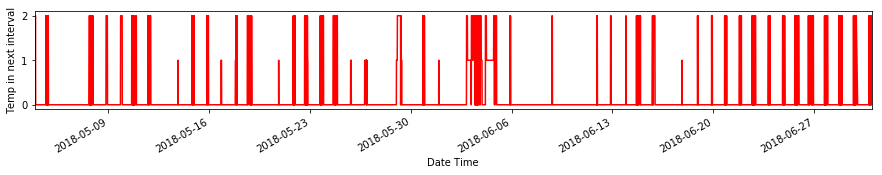

In [9]:
df = training_data['action']['2018-05':'2018-06']
ax = df.plot(color='red', figsize=(15,2))
ax.set_xlabel('Date Time')
ax.set_ylabel('Temp in next interval')
plt.show()

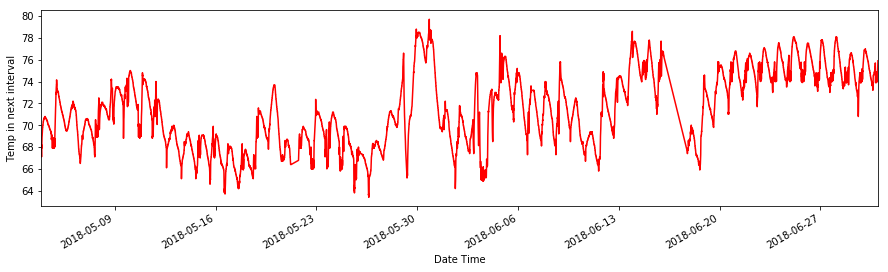

In [10]:
df = training_data['t_next']['2018-05':'2018-06']
ax = df.plot(color='red', figsize=(15,4))
ax.set_xlabel('Date Time')
ax.set_ylabel('Temp in next interval')
plt.show()

Feature to be predicted is t_next. This feature is seperated from all features and stored as train_y and test_y. 

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49744 entries, 2018-04-18 23:16:42+00:00 to 2018-10-25 23:08:42+00:00
Data columns (total 10 columns):
action                                        49744 non-null int64
action_duration                               49744 non-null float64
dt                                            49744 non-null float64
previous_action                               49744 non-null float64
t_next                                        49744 non-null float64
t_in                                          49744 non-null float64
t_out                                         49744 non-null float64
occ                                           49744 non-null float64
zone_temperatureHVAC_Zone_Shelter_Corridor    49744 non-null float64
t_last                                        49744 non-null float64
dtypes: float64(9), int64(1)
memory usage: 5.4 MB


In [12]:
train_y = training_data['t_next']
train_y

time
2018-04-18 23:16:42+00:00    69.500000
2018-04-18 23:21:42+00:00    69.500000
2018-04-18 23:26:42+00:00    69.500000
2018-04-18 23:31:42+00:00    69.400000
2018-04-18 23:36:42+00:00    69.500000
2018-04-18 23:41:42+00:00    69.400000
2018-04-18 23:46:42+00:00    69.500000
2018-04-18 23:51:42+00:00    69.500000
2018-04-18 23:56:42+00:00    69.500000
2018-04-19 00:01:42+00:00    69.500000
2018-04-19 00:06:42+00:00    69.500000
2018-04-19 00:11:42+00:00    69.400000
2018-04-19 00:16:42+00:00    69.400000
2018-04-19 00:21:42+00:00    69.200000
2018-04-19 00:26:42+00:00    69.100000
2018-04-19 00:31:42+00:00    69.100000
2018-04-19 00:36:42+00:00    69.100000
2018-04-19 00:41:42+00:00    69.000000
2018-04-19 00:46:42+00:00    69.000000
2018-04-19 00:51:42+00:00    68.900000
2018-04-19 00:56:42+00:00    68.900000
2018-04-19 01:01:42+00:00    68.833333
2018-04-19 01:06:42+00:00    68.866667
2018-04-19 01:11:42+00:00    68.816667
2018-04-19 01:16:42+00:00    68.800000
2018-04-19 01:21:42+

In [13]:

training_data = training_data.drop(['t_next', 'dt', 'action_duration', 'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1).values
#print train_.shape
#train_X
training_data

array([[  0.        ,  -1.        ,  69.48333333,  66.4997002 ,
          0.        ,  69.48333333],
       [  0.        ,  -1.        ,  69.5       ,  66.49969995,
          0.        ,  69.48333333],
       [  0.        ,  -1.        ,  69.5       ,  66.52054554,
          0.        ,  69.5       ],
       ..., 
       [  0.        ,   2.        ,  69.        ,  76.999613  ,
          0.        ,  68.9       ],
       [  0.        ,   2.        ,  69.4       ,  76.999613  ,
          0.        ,  69.        ],
       [  0.        ,   2.        ,  69.6       ,  76.999613  ,
          0.        ,  69.4       ]])

In [14]:
train_X = training_data
train_X

array([[  0.        ,  -1.        ,  69.48333333,  66.4997002 ,
          0.        ,  69.48333333],
       [  0.        ,  -1.        ,  69.5       ,  66.49969995,
          0.        ,  69.48333333],
       [  0.        ,  -1.        ,  69.5       ,  66.52054554,
          0.        ,  69.5       ],
       ..., 
       [  0.        ,   2.        ,  69.        ,  76.999613  ,
          0.        ,  68.9       ],
       [  0.        ,   2.        ,  69.4       ,  76.999613  ,
          0.        ,  69.        ],
       [  0.        ,   2.        ,  69.6       ,  76.999613  ,
          0.        ,  69.4       ]])

In [15]:
test_y = test_data['t_next']
test_y

time
2018-03-20 00:00:00+00:00    72.800000
2018-03-20 00:05:00+00:00    73.000000
2018-03-20 00:10:00+00:00    73.000000
2018-03-20 00:15:00+00:00    73.000000
2018-03-20 00:20:00+00:00    73.000000
2018-03-20 00:25:00+00:00    73.000000
2018-03-20 00:30:00+00:00    73.000000
2018-03-20 00:35:00+00:00    73.100000
2018-03-20 00:40:00+00:00    73.100000
2018-03-20 00:45:00+00:00    73.100000
2018-03-20 00:50:00+00:00    73.100000
2018-03-20 00:55:00+00:00    73.100000
2018-03-20 01:00:00+00:00    73.200000
2018-03-20 01:05:00+00:00    73.100000
2018-03-20 01:10:00+00:00    73.200000
2018-03-20 01:15:00+00:00    73.200000
2018-03-20 01:20:00+00:00    73.200000
2018-03-20 01:25:00+00:00    73.200000
2018-03-20 01:30:00+00:00    73.200000
2018-03-20 01:35:00+00:00    73.200000
2018-03-20 01:40:00+00:00    73.300000
2018-03-20 01:45:00+00:00    73.300000
2018-03-20 01:50:00+00:00    73.300000
2018-03-20 01:55:00+00:00    73.300000
2018-03-20 02:00:00+00:00    73.300000
2018-03-20 02:05:00+

In [16]:
test_X = test_data.drop(['t_next', 'dt', 'action_duration', 'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1).values
test_X

array([[  0.        ,  -1.        ,  72.8       ,  67.7786126 ,
          0.        ,  72.8       ],
       [  0.        ,  -1.        ,  72.8       ,  67.80743608,
          0.        ,  72.8       ],
       [  0.        ,  -1.        ,  73.        ,  67.83599835,
          0.        ,  72.8       ],
       ..., 
       [  0.        ,   2.        ,  72.3       ,  87.76877999,
          0.        ,  72.3       ],
       [  0.        ,   2.        ,  72.3       ,  87.79317891,
          0.        ,  72.3       ],
       [  0.        ,   2.        ,  72.4       ,  87.79317891,
          0.        ,  72.3       ]])

# Linear Regression Modelling

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time 

def LinearRegressionClassifier(train_X, train_y, test_X, test_y):
    t0 = time.time()
    linearModel = LinearRegression().fit(train_X, train_y)
    print("training time:", round(time.time()-t0, 3), "s")

    t1 = time.time()
    score = linearModel.score(test_X, test_y)
    print("testing time:", round(time.time()-t1, 3), "s")

    print("score: ", score)
    
    test_pred = linearModel.predict(test_X)
    print("rmse=", sqrt(mean_squared_error(test_y, test_pred)))
    
    #return linearModel

In [18]:
LinearRegressionClassifier(train_X, train_y, test_X, test_y)


training time: 0.223 s
testing time: 0.007 s
score:  0.992579778058
rmse= 0.23065143345237432


# Standardising dataset 

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
train_scaled = scaler.transform(train_X)
test_scaled = scaler.transform(test_X)

# PCA

In [20]:
LinearRegressionClassifier(train_scaled, train_y, test_scaled, test_y)

training time: 0.078 s
testing time: 0.012 s
score:  0.992579778058
rmse= 0.2306514334523742


In [21]:
from sklearn.decomposition import PCA

pca = PCA(0.97)

In [22]:
pca.fit(train_scaled)

PCA(copy=True, iterated_power='auto', n_components=0.97, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
train_pca = pca.transform(train_scaled)
test_pca = pca.transform(test_scaled)
                         
print("Training Data after PCA: ", train_pca)                        

Training Data after PCA:  [[ 2.05782252 -0.03182233 -1.5223914   0.23021458  0.27022855]
 [ 2.05483473 -0.03251188 -1.52297148  0.23050481  0.26852558]
 [ 2.05092867 -0.03299046 -1.52346929  0.2306758   0.26825251]
 ..., 
 [ 1.52495808 -0.20608115  0.866902   -0.19576097  0.87484527]
 [ 1.4353462  -0.22685801  0.84959879 -0.18705694  0.82353953]
 [ 1.3278735  -0.25204357  0.82911195 -0.1766202   0.76136456]]


In [24]:
pca.n_components_ 

5

In [25]:
train_pca.shape

(49744, 5)

# Linear Regression after PCA

In [26]:
LinearRegressionClassifier(train_pca, train_y, test_pca, test_y)

training time: 0.024 s
testing time: 0.0 s
score:  0.980799135966
rmse= 0.3710292055496929


# Linear Regression before PCA

In [27]:
LinearRegressionClassifier(train_X, train_y, test_X, test_y)


training time: 0.027 s
testing time: 0.002 s
score:  0.992579778058
rmse= 0.23065143345237432
